# K.P model for Weyl fermions

In this tutorial we wil investigate the properties of a Weyl Hamiltonian

# First, import needed modules

In [1]:
# So, first import the necessary modules

import wannierberri as wberri
print (f"Using WannierBerri version {wberri.__version__}")
import pythtb
import numpy as np
from copy import copy, deepcopy
import matplotlib.pyplot as plt

Using WannierBerri version 0.14.3.lindhard


## Define Parallel environment

In [2]:
#  This block is needed if you run this cell for a second time
#  because one cannot initiate two parallel environments at a time
try:
    parallel.shutdown()
except NameError:
    pass

# Chiose one of the options:

#parallel = wberri.Parallel(num_cpus=2)
parallel = wberri.Parallel()  # automatic detection
#parallel = wberri.Serial()

2023-10-25 15:42:54,576	INFO worker.py:1519 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8266 


## Free-electron k.p model

For simplicity, it is a 1-band free-electron

In [3]:
# hamiltonian takes k-vector in reciprocal angstroms and gives hamiltonian in eV
mass = 1.0   # in units Ang^2/eV
alpha=0  # anharmonicity
def ham(k):
    return np.array([[np.dot(k,k)/(2*mass)+alpha*np.dot(k,k)*4]])
# k.p model is bounded to a box of size 2*kmax
system_kp = wberri.system.SystemKP(Ham=ham, kmax=1)

Number of wannier functions: 1


In [4]:
from wannierberri.calculators.tabulate import Tabulator
from wannierberri.formula import Matrix_ln, transform_ident

class Eavlnq(Matrix_ln):

    def __init__(self, data_K, q_recip=None, q_cart=None):
        if q_recip is None:
            q_recip = np.dot(q_cart,np.linalg.inv(data_K.system.recip_lattice))
        EKq = data_K.E_K_q(q_recip)
        super().__init__(0.5 * (EKq[:, :, None] + EKq[:, None, :]))
        self.ndim = 0
        self.transformTR=transform_ident
        self.transformInv=transform_ident
        
class Energy_q(Tabulator):

    def __init__(self,**kwargs):
        super().__init__(Eavlnq,**kwargs)



In [11]:
path=wberri.Path(system_kp,
                 k_nodes=[
        [0.0000, 0.0000, 0.0000 ],   #  G
        [1.0 ,1.0, 1.0],   #  G
        [0.0, 1.0, 1.0],   #  G
        [0.0,1.0,0.0]   #  G
                 ] ,
                 labels=["G0","G111","G011","G010"],
                 length=200 )   # length [ Ang] ~= 2*pi/dk

tabulators = { "Energy": wberri.calculators.tabulate.Energy(),
              "berry": wberri.calculators.tabulate.BerryCurvature(kwargs_formula={"external_terms":False}),
             "qEnergy" : Energy_q(kwargs_formula={"q_cart":[0.,0.,0.5]}),
             "qEnergy2" : Energy_q(kwargs_formula={"q_cart":[0.,0.,0.25]})
             }



tab_all_path = wberri.calculators.TabulatorAll(
                    tabulators,
                    # ibands = np.arange(0,18),
                    mode = "path"
                        )

calculator not described

calculator not described

calculator not described

calculator not described



In [12]:
result=wberri.run(system_kp,
                  grid=path,
                  calculators = {"tabulate" : tab_all_path},
                  parallel = parallel,
                  print_Kpoints = False)

print (result.results)
path_result = result.results["tabulate"]

Calculation along a path - checking calculators for compatibility
tabulate <wannierberri.calculators.TabulatorAll object at 0x7f38c0170a00>
All calculators are compatible
Symmetrization switched off for Path
Grid is regular
The set of k points is a Path() with 239 points and labels {0: 'G0', 110: 'G111', 174: 'G011', 238: 'G010'}
generating K_list
Done 
Done, sum of weights:239.0
symgroup : None
processing 239 K points : using  8 processes.
# K-points calculated  Wall time (sec)  Est. remaining (sec)
time for processing    239 K-points on   8 processes:     0.3665 ; per K-point          0.0015 ; proc-sec per K-point          0.0123
time1 =  0.029946327209472656
Totally processed 239 K-points 
{'tabulate': <wannierberri.result.__tabresult.TABresult object at 0x7f38c01729b0>}


## Plot bands

The `TABresult` object already provides methods to plot the results. (As well as one can extract the data and plot them by other means). Below let’s plot the interpolated bands and compare with those obtained in QE. (file “bands/Fe_bands_pw.dat” is already provided)

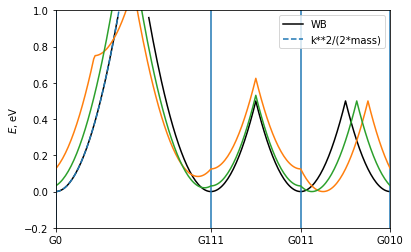

In [15]:
path_result = result.results["tabulate"]
eq=path_result.get_data("qEnergy",iband=0)
eq2=path_result.get_data("qEnergy2",iband=0)
plt.close()
path_result.plot_path_fat( path,
              quantity=None,
#              Eshift=EF,
              Emin=-0.2,  Emax=1,
              iband=None,
              mode="fatband",
              fatfactor=20,
              cut_k=False,
              close_fig=False,
              show_fig=False,
              label = "WB"
              )

kline = path.getKline()
plt.plot(kline,kline**2/(2*mass),"--",label="k**2/(2*mass)")
plt.plot(kline,eq)
plt.plot(kline,eq2)
plt.legend()
plt.show()
plt.close()

## Definition of calculator for Lindhard function

In [8]:
Efermi = np.linspace(-0.1,0.6,71)
from wannierberri.calculators.dynamic import Calculator
from wannierberri.result import EnergyResult
from wannierberri.symmetry import transform_ident

class Lindhard(Calculator):
    "evaluates :matm:`\int [dk] \sum_{mn}\frac{\theta(E_F-E_m)-\theta(E_F-E_n)}{(E_m-E_n+i\eta)}`"

    def __init__(self,q,Efermi,eta=1e-3):
        self.q=np.copy(q) # q in reciprocal coordinates
        self.Efermi=np.copy(Efermi)
        self.eta=eta

    def linhard_q(self,EK,EKq):
        res = np.zeros( (self.Efermi.shape[0], ), dtype = complex)
        frac=1/(EK[:,:,None]-EKq[:,None,:]+1j*self.eta)
        return np.array([frac[(EK<EF)[:,:,None]].sum()-frac[(EKq<EF)[:,None,:]].sum() for EF in self.Efermi])

    def __call__(self,data_K):
        EK=data_K.E_K
        restot=[]
        for q in self.q:
            EKq=data_K.E_K_q(q)
            restot.append(self.linhard_q(EK,EKq))
        restot = np.array(restot)/data_K.nk * data_K.cell_volume
        return EnergyResult(Energies = [self.q,self.Efermi],
                            E_titles = ["q","Efermi"],
                            data= restot,
                            transformTR=transform_ident, transformInv=transform_ident)

        

calculators = {
                "lindhard":Lindhard(q=[[0,0,0],[0.025,0,0],[0.05,0,0],[0.1,0,0],[0.2,0,0]],Efermi=Efermi)
              }

grid = wberri.Grid(system_kp, NK=80, NKFFT=10 )
result_run = wberri.run(system_kp,
            grid=grid,
            calculators = calculators,
            parallel=parallel,
            adpt_num_iter=0,
            fout_name='kp',
            restart=False,
            print_Kpoints=False
            #file_Klist="Klist_ahc.pickle"  # needed to restart a calculation in future
            )

determining grids from NK=80 (<class 'int'>), NKdiv=None (<class 'NoneType'>), NKFFT=10 (<class 'NoneType'>)
The grids were set to NKdiv=[8 8 8], NKFFT=[10 10 10], NKtot=[80 80 80]
Grid is regular
The set of k points is a Grid() with NKdiv=[8 8 8], NKFFT=[10 10 10], NKtot=[80 80 80]
generating K_list
Done in 0.008117198944091797 s 
excluding symmetry-equivalent K-points from initial grid
Done in 0.044474124908447266 s 
Done in 0.04460549354553223 s 
K_list contains 512 Irreducible points(100.0%) out of initial 8x8x8=512 grid
Done, sum of weights:1.0
symgroup : Real_lattice:
[[3.1416 0.     0.    ]
 [0.     3.1416 0.    ]
 [0.     0.     3.1416]]
 Recip. Lattice:
 [[2. 0. 0.]
 [0. 2. 0.]
 [0. 0. 2.]]
 size:1
Operations:
0:
rotation:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] , TR: False , I: False

processing 512 K points : using  8 processes.
# K-points calculated  Wall time (sec)  Est. remaining (sec)
time for processing    512 K-points on   8 processes:    13.8139 ; per K-point          0.

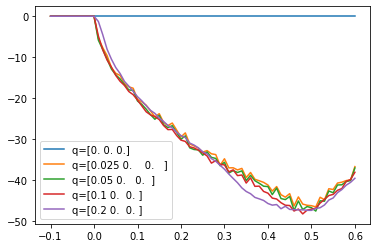

In [9]:
for i in range(5):
    q=result_run.results["lindhard"].Energies[0][i]
    plt.plot(Efermi,result_run.results["lindhard"].data[i].real,label=f"q={q}")
    #plt.plot(Efermi,result_run.results["lindhard"].data[i].imag,label=f"imag q={q}")
    plt.legend()